# Q-Trainer for QAOA

In [15]:
import qtrainer
import networkx as nx
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define a graph

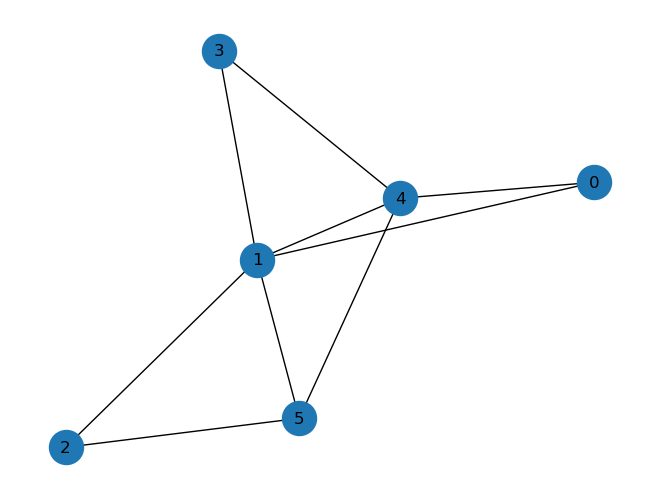

In [18]:
n_nodes = 6
p = 0.5  # probability of an edge
seed = 2023

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions, node_size=600)

## Q-Trainer's QAOA Circuit class
Available QAOA Tasks:
- `maxcut`: Maximum Cut
- `max_clique`: Maximum Clique
- `max_independent_set`: Maximum Independent Set
- `max_weight_cycle`: Maximum Weighted Cycle
- `min_vertex_cover`: Minimum Vertex Cover

In [19]:
task = "maxcut"
depth = 1
circuit = qtrainer.circuits.QAOACircuit(graph=g, task=task, depth=depth, seed=0)

In [20]:
from mitiq.interface.mitiq_pennylane import (
    from_pennylane,
    to_pennylane,
    UnsupportedQuantumTapeError,
)
from mitiq.interface.mitiq_braket.conversions import from_braket, to_braket,_translate_cirq_operation_to_braket_instruction
from mitiq.interface.mitiq_qiskit.conversions import (
    from_qasm,
    from_qiskit,
    to_qasm,
    to_qiskit,
)
from mitiq.interface.mitiq_pyquil.conversions import (
    from_pyquil,
    from_quil,
    to_pyquil,
    to_quil,
)

with qml.tape.QuantumTape() as tape:
    circuit.ansatz(*circuit.params, n_qubits=circuit.n_qubits, depth=circuit.depth)

In [36]:
from mitiq.interface.mitiq_qiskit import from_qasm as cirq_from_qasm, to_qasm

## Noise Model
Depolarization noise on all gates

In [4]:
noise_gate = qml.DepolarizingChannel
noise_strength = 0.1
noise_fn = qml.transforms.insert(noise_gate, noise_strength, position="all")

## Trainer
+ `circuit`: Q-Trainer Circuit class
+ `device_name`: Pennylane-stype device name. (For noised simulation, use `default.mixed`.)
+ `optimizer`: could be `Adam`, `SGD`, `ShotAdaptive`, `SPSA`, etc.
+ `noise_fn`: preset noise function
+ `error_mitigation_method`: Quantum error mitigation method. Currently, only Zero-Noise Zxtrapolation (`zne`) is supported
+ `n_steps`: number of optimization steps

In [5]:
my_bucket = "amazon-braket-play"
# the name of the folder in the bucket
my_prefix = "simulation-output"
s3_folder = (my_bucket, my_prefix)
device_arn='arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2'
device_arn='arn:aws:braket:::device/qpu/ionq/ionQdevice'

In [6]:
train_config = dict(
    device_name = 'braket.aws.qubit',#'default.mixed',
    device_config = {"s3_destination_folder":s3_folder, "device_arn":device_arn,
        "poll_timeout_seconds":1800, },
    optimizer = 'Adam',
    optimizer_config={'stepsize': 1},
    n_steps = 5,
    shots_per_step = 10,
    # noise_fn = noise_fn,
)

**Trainer with Zero-Noise Extrapolation**

In [6]:
trainer_zne = qtrainer.Trainer(circuit, 
                                        error_mitigation_method='zne',
                                        **train_config
                                        )

**Start training!**

In [68]:
log = trainer_zne.train()

NameError: name 'trainer_zne' is not defined

**For comparison, we train a circuit without error mitigation as a baseline.**

In [8]:
circuit_base = qtrainer.circuits.QAOACircuit(graph=g, task=task, depth=depth, seed=0)
trainer_base = qtrainer.Trainer(circuit_base, 
                                        error_mitigation_method=None,
                                        grad_method='finite-diff',
                                        **train_config
                                        )

In [10]:
trainer_base.cost_fn(*trainer_base.params)

AttributeError: 'NoneType' object has no attribute 'result_types'

In [109]:
# sleep for 7hr
from time import sleep,time
t0 = time()
log = trainer_base.train()
print(f"Elapsed time: {time()-t0}")

Train:   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute 'result_types'

In [99]:
dev_qpu = qml.device(
    "braket.aws.qubit",
    s3_destination_folder=s3_folder, 
    device_arn=device_arn,
    poll_timeout_seconds=1800, wires=2,shots=10,
)
@qml.qnode(dev_qpu, diff_method="finite-diff",)
def circuit(a):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RX(a, wires=1)
    return qml.expval(qml.PauliZ(1))

ValueError: QPU devices do not support 0 shots

In [ ]:
from time import time
t0 = time()
x = qml.numpy.array(0.543, requires_grad=True)
print(qml.grad(circuit)(x))
print(time()-t0)

TypeError: pennylane.gradients.finite_difference.finite_diff() got multiple values for keyword argument 'shots'

## Evaluation

In [ ]:
def cut_size(measurement, graph):
    S = np.argwhere(measurement == 1).flatten()
    T = np.argwhere(measurement == 0).flatten()
    return nx.cut_size(graph, S, T)

def est_measurement_prob(trainer,shots=10000):
    shots = 10000
    wires = trainer.n_qubits
    s = measurements = trainer.sample_measurement(shots=shots).T.numpy()
    s = (1 - s) / 2
    s = map(tuple, s)
    counts = Counter(s)
    indx = np.ndindex(*[2] * wires)
    probs = {p: counts.get(p, 0) / shots for p in indx}
    return probs
def plot_maxcut_results(probs,cuts,n_qubits:int,title=None):
    plt.style.use("seaborn")
    labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(range(2 ** n_qubits), probs.values(),label='Measurement Probability')
    normalized_cuts = np.array(list(cuts.values())) / max(list(cuts.values())) * max(list(probs.values()))*1.1
    ax.set_xticks([i for i in range(len(probs))], labels, rotation='vertical', size=12)
    # ax.set_yticks(size=12)

    ax.set_xlabel("Sample", size=20)
    ax.set_ylabel("Probability", size=20)

    # ax2 = plt.twinx()
    ax.bar(range(2 ** n_qubits), normalized_cuts, alpha=0.2, color='orange',label='Cut Size')

    # ax2.set_yticks(np.linspace(0,normalized_cuts.max(),)
    ax.set_title(title,size=20)
    plt.legend(prop={'size': 15})
    
    fig = plt.gcf()
    fig.set_size_inches(16, 8)
    return fig

In [ ]:
### Circuits Trained with & without Quantum Error Mitigatation

In [ ]:
probs = est_measurement_prob(trainer_zne)
cuts = {k: cut_size(np.array(k), g) for k in probs.keys()}
fig_zne = plot_maxcut_results(probs,cuts,n_qubits=n_nodes,title='With Mitigation')

probs = est_measurement_prob(trainer_base)
cuts = {k: cut_size(np.array(k), g) for k in probs.keys()}
fig_base = plot_maxcut_results(probs,cuts,n_qubits=n_nodes,title='No Mitigation')

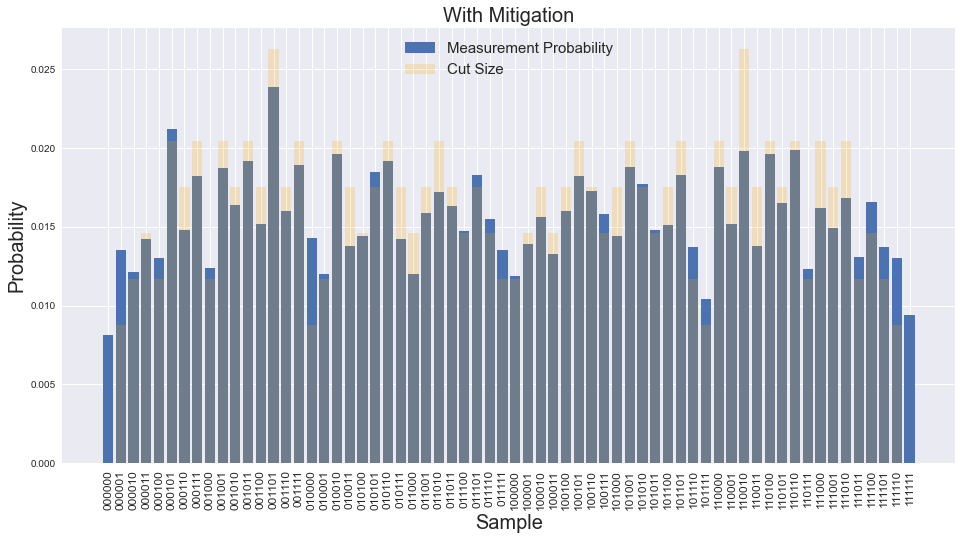

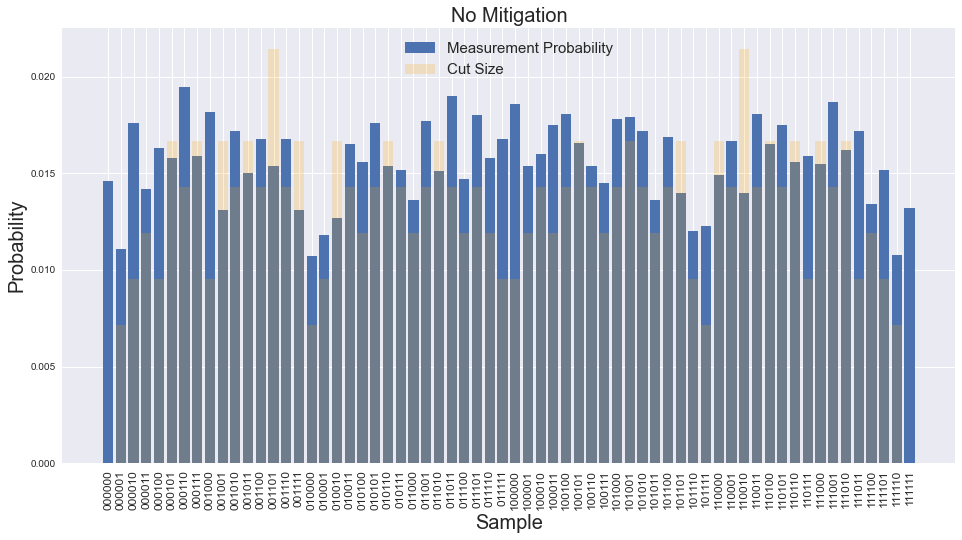

In [19]:
probs = est_measurement_prob(trainer_zne)
cuts = {k: cut_size(np.array(k), g) for k in probs.keys()}
fig_zne = plot_maxcut_results(probs,cuts,n_qubits=n_nodes,title='With Mitigation')

probs = est_measurement_prob(trainer_base)
cuts = {k: cut_size(np.array(k), g) for k in probs.keys()}
fig_base = plot_maxcut_results(probs,cuts,n_qubits=n_nodes,title='No Mitigation')